In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
from math import ceil

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,make_scorer
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC


#from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.model_selection import cross_validate,  RepeatedStratifiedKFold,cross_val_score,GridSearchCV, train_test_split,cross_val_score
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score,make_scorer

import mlflow

In [2]:
warnings.filterwarnings("ignore")

In [3]:
class Diabetes:
    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self):
        X = self.filepath.data.features
        y = self.filepath.data.targets
        # get the dataset with all the variables
        data = X.copy()
        data['Diabetes_binary'] = y
        return data

    def explore_data(self, data):
        print(self.filepath.metadata)  ## considerar
        print(self.filepath.variables) ## considerar
        print(data.head())
        print(data.describe().T) ## considerar
        print(data.info()) ## considerar
        print(data.shape)
        print(data.isnull().sum())
        print(data.dtypes)
        
    def preprocess_conversion_cols(self, data):
        # Automatically find binary columns
        binary_columns = [col for col in data.columns if set(data[col].unique()).issubset({0, 1})]
        
        # Convert found binary columns to bool
        for col in binary_columns:
            data[col] = data[col].astype('bool')
        
        # List of categorical columns to convert
        categorical_columns = ['GenHlth', 'Age', 'Education', 'Income']
        
        # Convert specified columns to category
        for col in categorical_columns:
            data[col] = data[col].astype('category')
        
        # Check the data types
        #print(data.dtypes)

    def explore_different_transformations(self, data):
        # Crear un DataFrame temporal para las transformaciones
        temp_data = data.copy()

        # Crear las transformaciones en el DataFrame temporal
        temp_data['Log_BMI'] = np.log(temp_data['BMI'] + 1)
        temp_data['Log_MentHlth'] = np.log(temp_data['MentHlth'] + 1)
        temp_data['Log_PhysHlth'] = np.log(temp_data['PhysHlth'] + 1)

        temp_data['Sqrt_BMI'] = np.sqrt(temp_data['BMI'] + 1)
        temp_data['Sqrt_MentHlth'] = np.sqrt(temp_data['MentHlth'] + 1)
        temp_data['Sqrt_PhysHlth'] = np.sqrt(temp_data['PhysHlth'] + 1)

        # Yeo-Johnson Transformation
        pt = PowerTransformer(method='yeo-johnson')
        temp_data[['YeoJohnson_BMI', 'YeoJohnson_MentHlth', 'YeoJohnson_PhysHlth']] = pt.fit_transform(temp_data[['BMI', 'MentHlth', 'PhysHlth']])

        # Configurar la figura para múltiples subgráficas
        fig, axes = plt.subplots(5, 3, figsize=(15, 20))
        fig.suptitle('Comparación de Distribuciones de Variables Numéricas y Transformaciones', fontsize=16)

        # Originales
        for i, col in enumerate(['BMI', 'MentHlth', 'PhysHlth']):
            sns.histplot(data[col], bins=30, kde=True, ax=axes[0, i])
            axes[0, i].set_title(f'Distribución de {col}')
            axes[0, i].set_xlabel(col)
            axes[0, i].set_ylabel('Frecuencia')

        # Transformación Logarítmica
        for i, col in enumerate(['Log_BMI', 'Log_MentHlth', 'Log_PhysHlth']):
            sns.histplot(temp_data[col], bins=30, kde=True, ax=axes[1, i])
            axes[1, i].set_title(f'Distribución Log de {col}')
            axes[1, i].set_xlabel(col)
            axes[1, i].set_ylabel('Frecuencia')

        # Transformación de Raíz Cuadrada
        for i, col in enumerate(['Sqrt_BMI', 'Sqrt_MentHlth', 'Sqrt_PhysHlth']):
            sns.histplot(temp_data[col], bins=30, kde=True, ax=axes[2, i])
            axes[2, i].set_title(f'Distribución Raíz Cuadrada de {col}')
            axes[2, i].set_xlabel(col)
            axes[2, i].set_ylabel('Frecuencia')

        # Transformación Yeo-Johnson
        for i, col in enumerate(['YeoJohnson_BMI', 'YeoJohnson_MentHlth', 'YeoJohnson_PhysHlth']):
            sns.histplot(temp_data[col], bins=30, kde=True, ax=axes[3, i])
            axes[3, i].set_title(f'Distribución Yeo-Johnson de {col}')
            axes[3, i].set_xlabel(col)
            axes[3, i].set_ylabel('Frecuencia')

        # Ocupando el espacio en la última fila (puedes ajustar o agregar más gráficas)
        for ax in axes[4]:
            ax.axis('off')  # O puedes agregar otras gráficas aquí

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout
        plt.show()
    
    def apply_transformations(self, data):

        label_encoder = LabelEncoder()    
        # Aplica el Label Encoding a las columnas ordinales
        data['GenHlth'] = label_encoder.fit_transform(data['GenHlth'])
        data['Age'] = label_encoder.fit_transform(data['Age'])
        data['Education'] = label_encoder.fit_transform(data['Education'])
        data['Income'] = label_encoder.fit_transform(data['Income'])
        
        # Muestra el DataFrame transformado
        print(data[['GenHlth', 'Age', 'Education','Income']])
        pt = PowerTransformer(method='yeo-johnson')
        data[['BMI', 'MentHlth', 'PhysHlth']] = pt.fit_transform(data[['BMI', 'MentHlth', 'PhysHlth']])
        
        # Estandarizar las variables transformadas y reemplazar las columnas originales
        scaler = StandardScaler()
        data[['BMI', 'MentHlth', 'PhysHlth']] = scaler.fit_transform(data[['BMI', 'MentHlth', 'PhysHlth']])
        
        # Mostrar el DataFrame transformado y estandarizado
        print(data[['BMI', 'MentHlth', 'PhysHlth']])
        return data
    
    def apply_pca(self, data):

        X = data[['BMI', 'MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']]

        # Inicializa PCA y ajusta el modelo
        # Elegir cuántas componentes principales mantener
        pca = PCA() 
        X_pca = pca.fit_transform(X)

        # Variancia explicada por cada componente
        explained_variance = pca.explained_variance_ratio_
        

        # Crea un gráfico de codo
        plt.figure(figsize=(6, 6))
        plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
        plt.title('Varianza Explicada por Componentes Principales')
        plt.xlabel('Número de Componentes Principales')
        plt.ylabel('Proporción de Varianza Explicada')
        plt.grid()
        plt.show()

        # Crea un gráfico de varianza acumulada
        plt.figure(figsize=(6, 6))
        cumulative_variance = explained_variance.cumsum()
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
        plt.title('Varianza Acumulada por Componentes Principales')
        plt.xlabel('Número de Componentes Principales')
        plt.ylabel('Varianza Acumulada')
        plt.grid()
        plt.axhline(y=0.92, color='r', linestyle='--')  # Umbral del 92%
        plt.show()

        num_components = np.where(cumulative_variance >= 0.99)[0][0] + 1
        print(f"El número mínimo de componentes principales que explica más del 99% de la varianza es: {num_components}")

        pca = PCA(n_components=7) 
        X_pca = pca.fit_transform(X)
        
        # Convertir el resultado a un DataFrame
        pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(7)])
        
        # Unir las componentes principales con el DataFrame original, excluyendo las variables originales
        final_df = pd.concat([data.drop(columns=['BMI', 'MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']).reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)
        
        # Mostrar el DataFrame final
        print(final_df.head())
        return final_df

    def true_false_to_one_hot(self,df):
        df_converted=df.applymap(lambda x: 1 if x is True else (0 if x is False else x))
        return df_converted
    


In [10]:
class Plots:
    # 1. Summary Statistics
    def __init__(self, data, target):
        self.data=data
        self.target = target
    
    def summary_statistics(self):
        print("Summary Statistics:")
        print(self.data.describe(include='all'))
    
    # 2. Distribution of Numeric Variables
    def plot_numeric_distributions(self):
        numeric_columns = self.data.select_dtypes(include=['int64']).columns
        n_cols = 3  # Number of columns in the grid
        n_rows = ceil(len(numeric_columns) / n_cols)  # Calculate rows needed

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        for i, col in enumerate(numeric_columns):
            sns.histplot(self.data[col], bins=30, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True)

        # Hide any extra subplots that are not used
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    
    # 3. Count Plots for Binary Variables against the Target
    def plot_binary_counts(self):
        binary_columns = self.data.select_dtypes(include=['bool']).columns
        n_cols = 3  # Number of columns in the grid
        n_rows = ceil(len(binary_columns) / n_cols)  # Calculate rows needed

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        for i, col in enumerate(binary_columns):
            sns.countplot(x=self.data[col], hue=self.data[self.target], ax=axes[i])
            axes[i].set_title(f'Count of {col} by {self.target}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].legend(title=self.target)
            axes[i].grid(True)

        # Hide any extra subplots that are not used
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
    # 4. Box Plots for Continuous Variables by Target Variable
    def plot_boxplots(self):
        numeric_columns = self.data.select_dtypes(include=['int64']).columns
        n_cols = 3  # Number of columns in the grid
        n_rows = ceil(len(numeric_columns) / n_cols)  # Calculate rows needed

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axes = axes.flatten()  # Flatten the axes array for easy iteration

        for i, num_col in enumerate(numeric_columns):
            sns.boxplot(x=self.data[self.target], y=self.data[num_col], ax=axes[i])
            axes[i].set_title(f'Boxplot of {num_col} by {self.target}')
            axes[i].set_xlabel(self.target)
            axes[i].set_ylabel(num_col)
            axes[i].grid(True)

        # Hide any extra subplots that are not used
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    
    # 5. Crosstabulation for Categorical Variables against the Target
    def plot_crosstab(self):
        categorical_columns = self.data.select_dtypes(include=['category']).columns
        for cat_col in categorical_columns:
            crosstab = pd.crosstab(self.data[cat_col], self.data[self.target])
            print(f'Crosstab for {cat_col} vs {self.target}:')
            print(crosstab)
            sns.heatmap(crosstab, annot=True, fmt="d", cmap='Blues')
            plt.title(f'Crosstab Heatmap of {cat_col} by {self.target}')
            plt.ylabel(cat_col)
            plt.xlabel(self.target)
            plt.show()
    
    # 6. Correlation Heatmap for Numeric Variables
    def plot_correlation_heatmap(self):
        numeric_data = self.data.select_dtypes(include=['int64'])
        correlation_matrix = numeric_data.corr()
        plt.figure(figsize=(8, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
        plt.title('Correlation Heatmap')
        plt.show()

In [11]:
cdc_diabetes_health_indicators=fetch_ucirepo(id=891)
modelo=Diabetes(cdc_diabetes_health_indicators)
raw_data = modelo.load_data()
modelo.explore_data(raw_data)
modelo.preprocess_conversion_cols(raw_data)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

Summary Statistics:
        HighBP HighChol CholCheck            BMI  Smoker  Stroke  \
count   253680   253680    253680  253680.000000  253680  253680   
unique       2        2         2            NaN       2       2   
top      False    False      True            NaN   False   False   
freq    144851   146089    244210            NaN  141257  243388   
mean       NaN      NaN       NaN      28.382364     NaN     NaN   
std        NaN      NaN       NaN       6.608694     NaN     NaN   
min        NaN      NaN       NaN      12.000000     NaN     NaN   
25%        NaN      NaN       NaN      24.000000     NaN     NaN   
50%        NaN      NaN       NaN      27.000000     NaN     NaN   
75%        NaN      NaN       NaN      31.000000     NaN     NaN   
max        NaN      NaN       NaN      98.000000     NaN     NaN   

       HeartDiseaseorAttack PhysActivity  Fruits Veggies  ... NoDocbcCost  \
count                253680       253680  253680  253680  ...      253680   
unique   

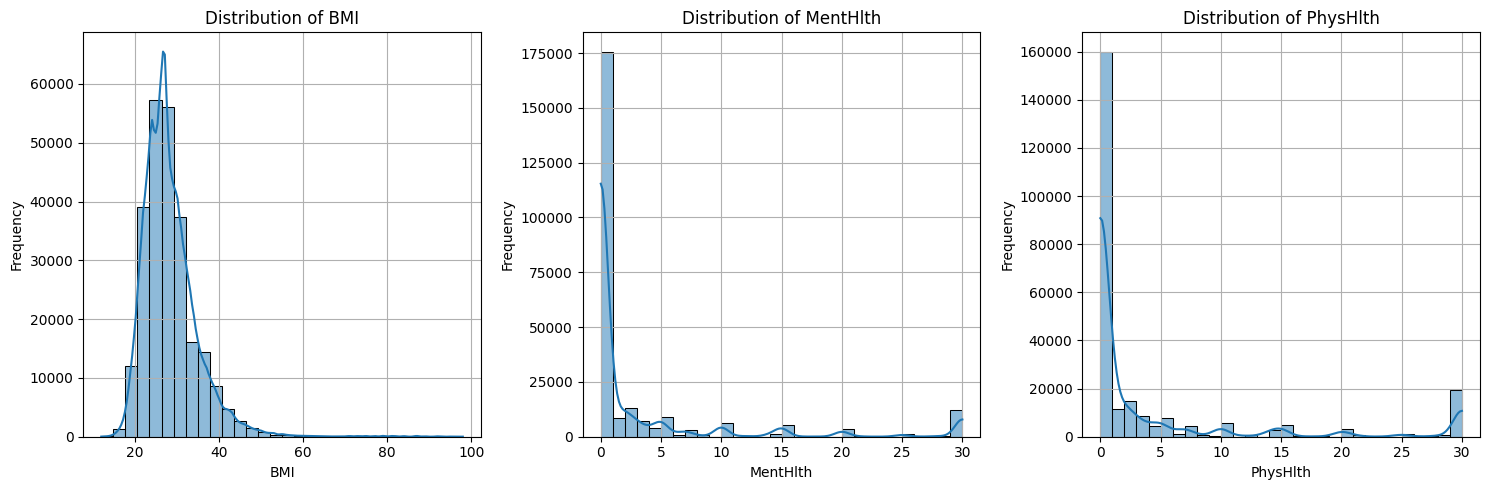

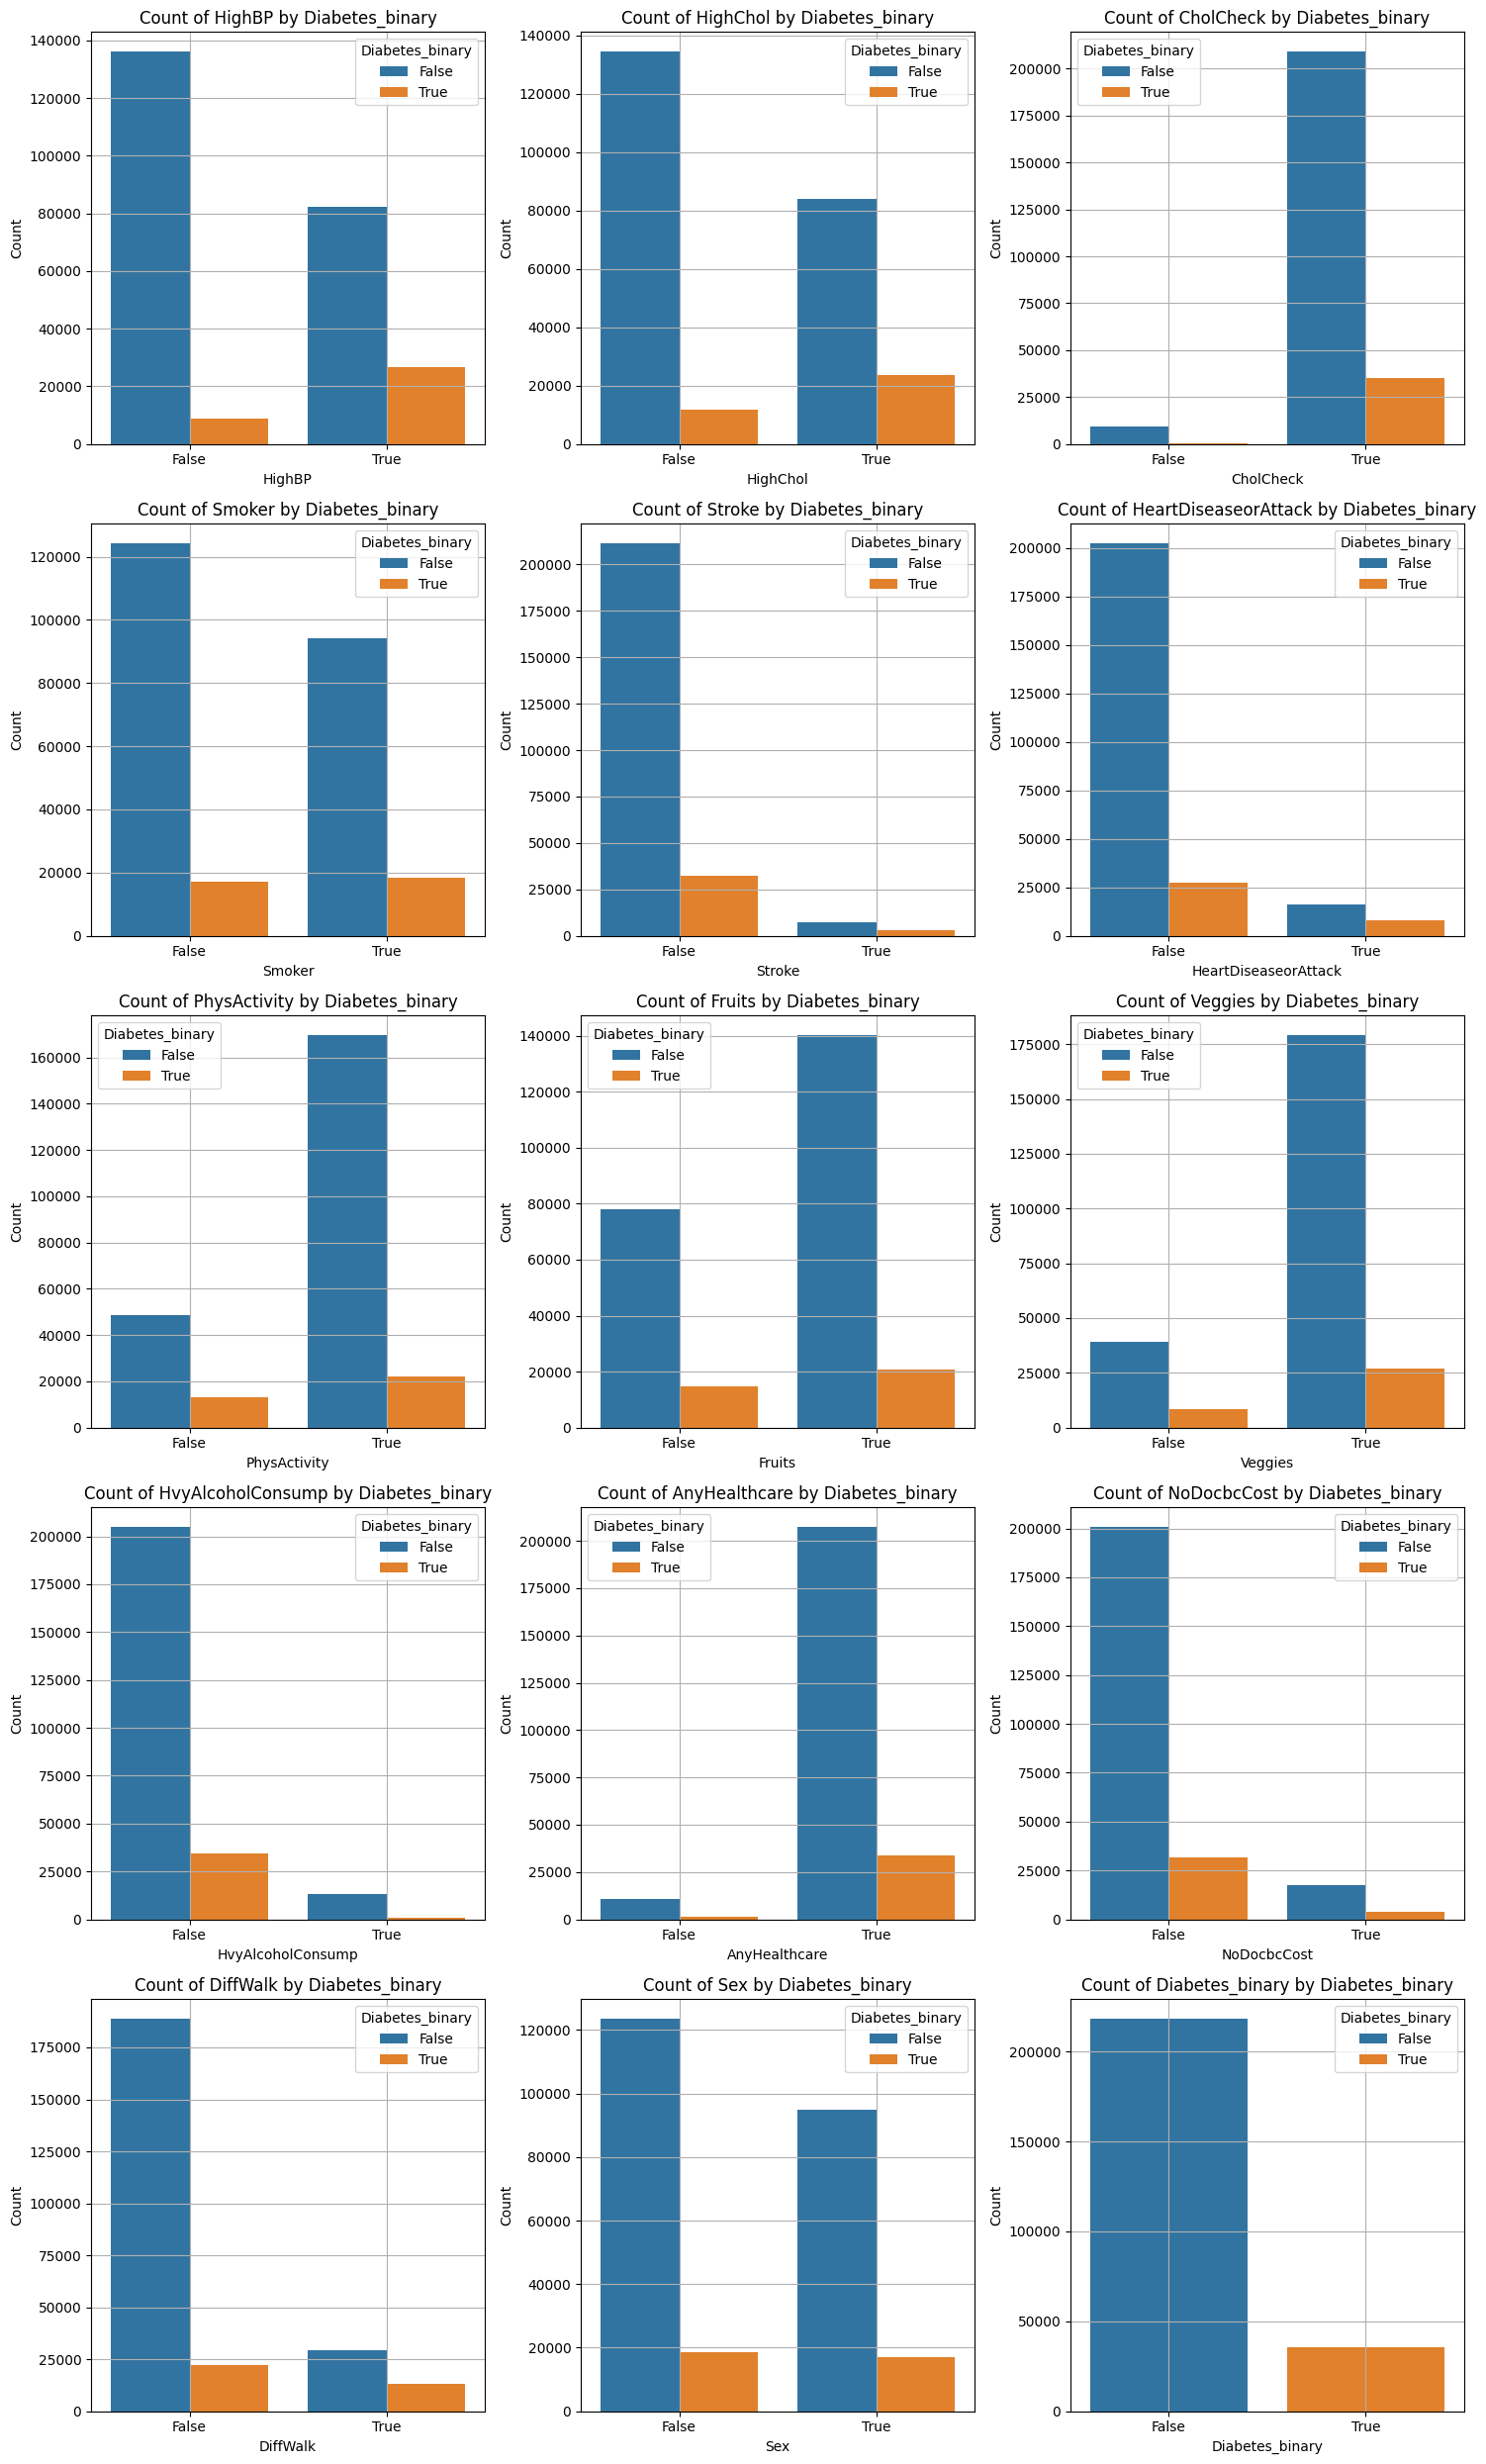

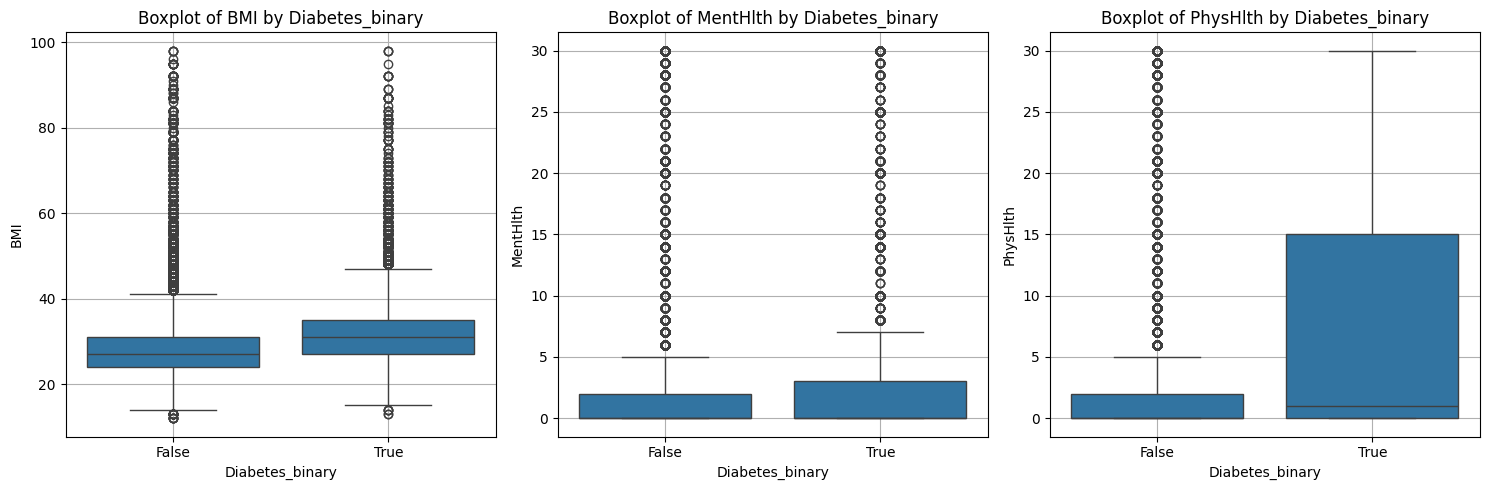

Crosstab for GenHlth vs Diabetes_binary:
Diabetes_binary  False  True 
GenHlth                      
1                44159   1140
2                82703   6381
3                62189  13457
4                21780   9790
5                 7503   4578


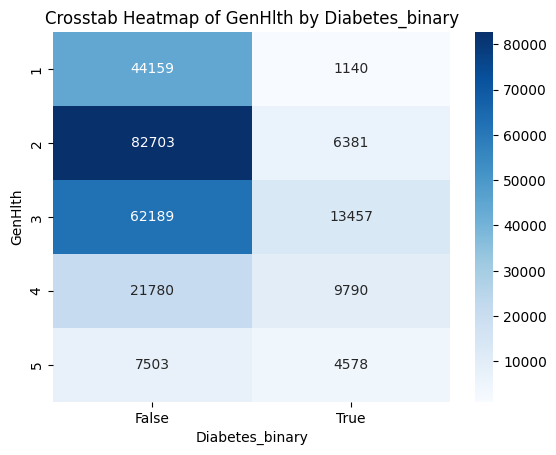

Crosstab for Age vs Diabetes_binary:
Diabetes_binary  False  True 
Age                          
1                 5622     78
2                 7458    140
3                10809    314
4                13197    626
5                15106   1051
6                18077   1742
7                23226   3088
8                26569   4263
9                27511   5733
10               25636   6558
11               18392   5141
12               12577   3403
13               14154   3209


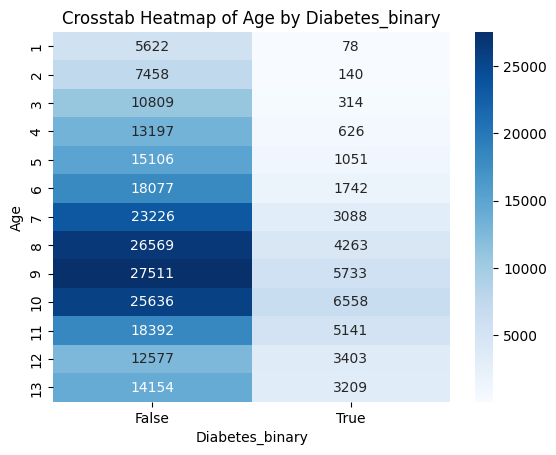

Crosstab for Education vs Diabetes_binary:
Diabetes_binary  False  True 
Education                    
1                  127     47
2                 2860   1183
3                 7182   2296
4                51684  11066
5                59556  10354
6                96925  10400


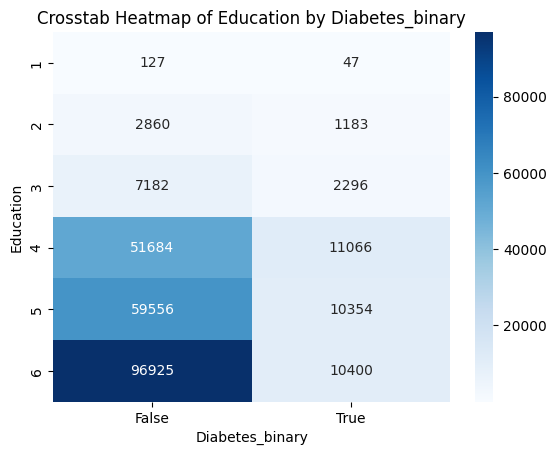

Crosstab for Income vs Diabetes_binary:
Diabetes_binary  False  True 
Income                       
1                 7428   2383
2                 8697   3086
3                12426   3568
4                16081   4054
5                21379   4504
6                31179   5291
7                37954   5265
8                83190   7195


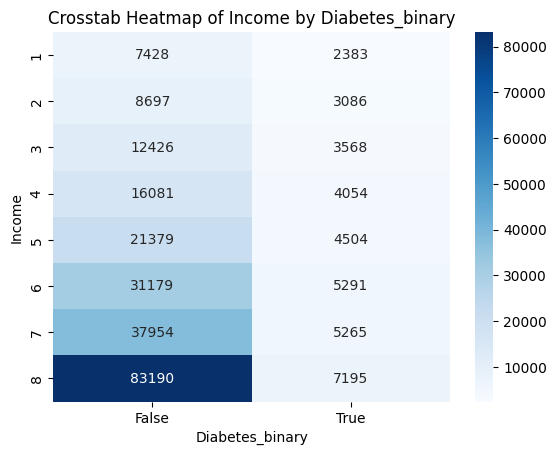

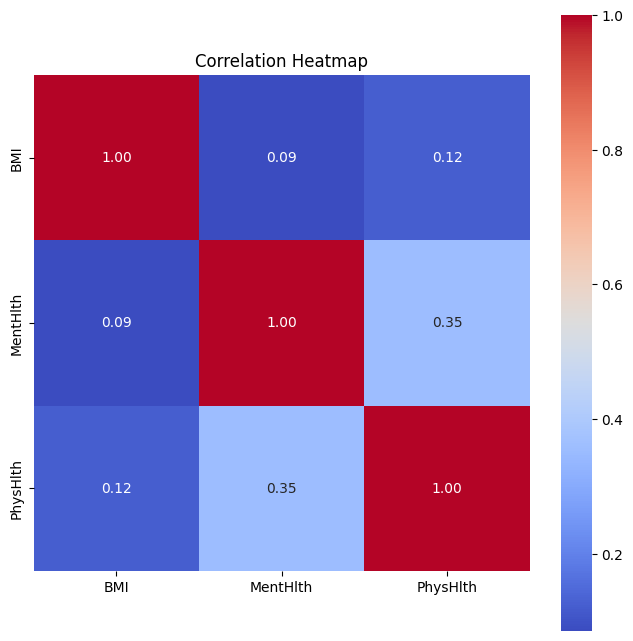

In [12]:
plots = Plots(raw_data, "Diabetes_binary")
plots.summary_statistics()
plots.plot_numeric_distributions()
plots.plot_binary_counts()
plots.plot_boxplots()
plots.plot_crosstab()
plots.plot_correlation_heatmap()

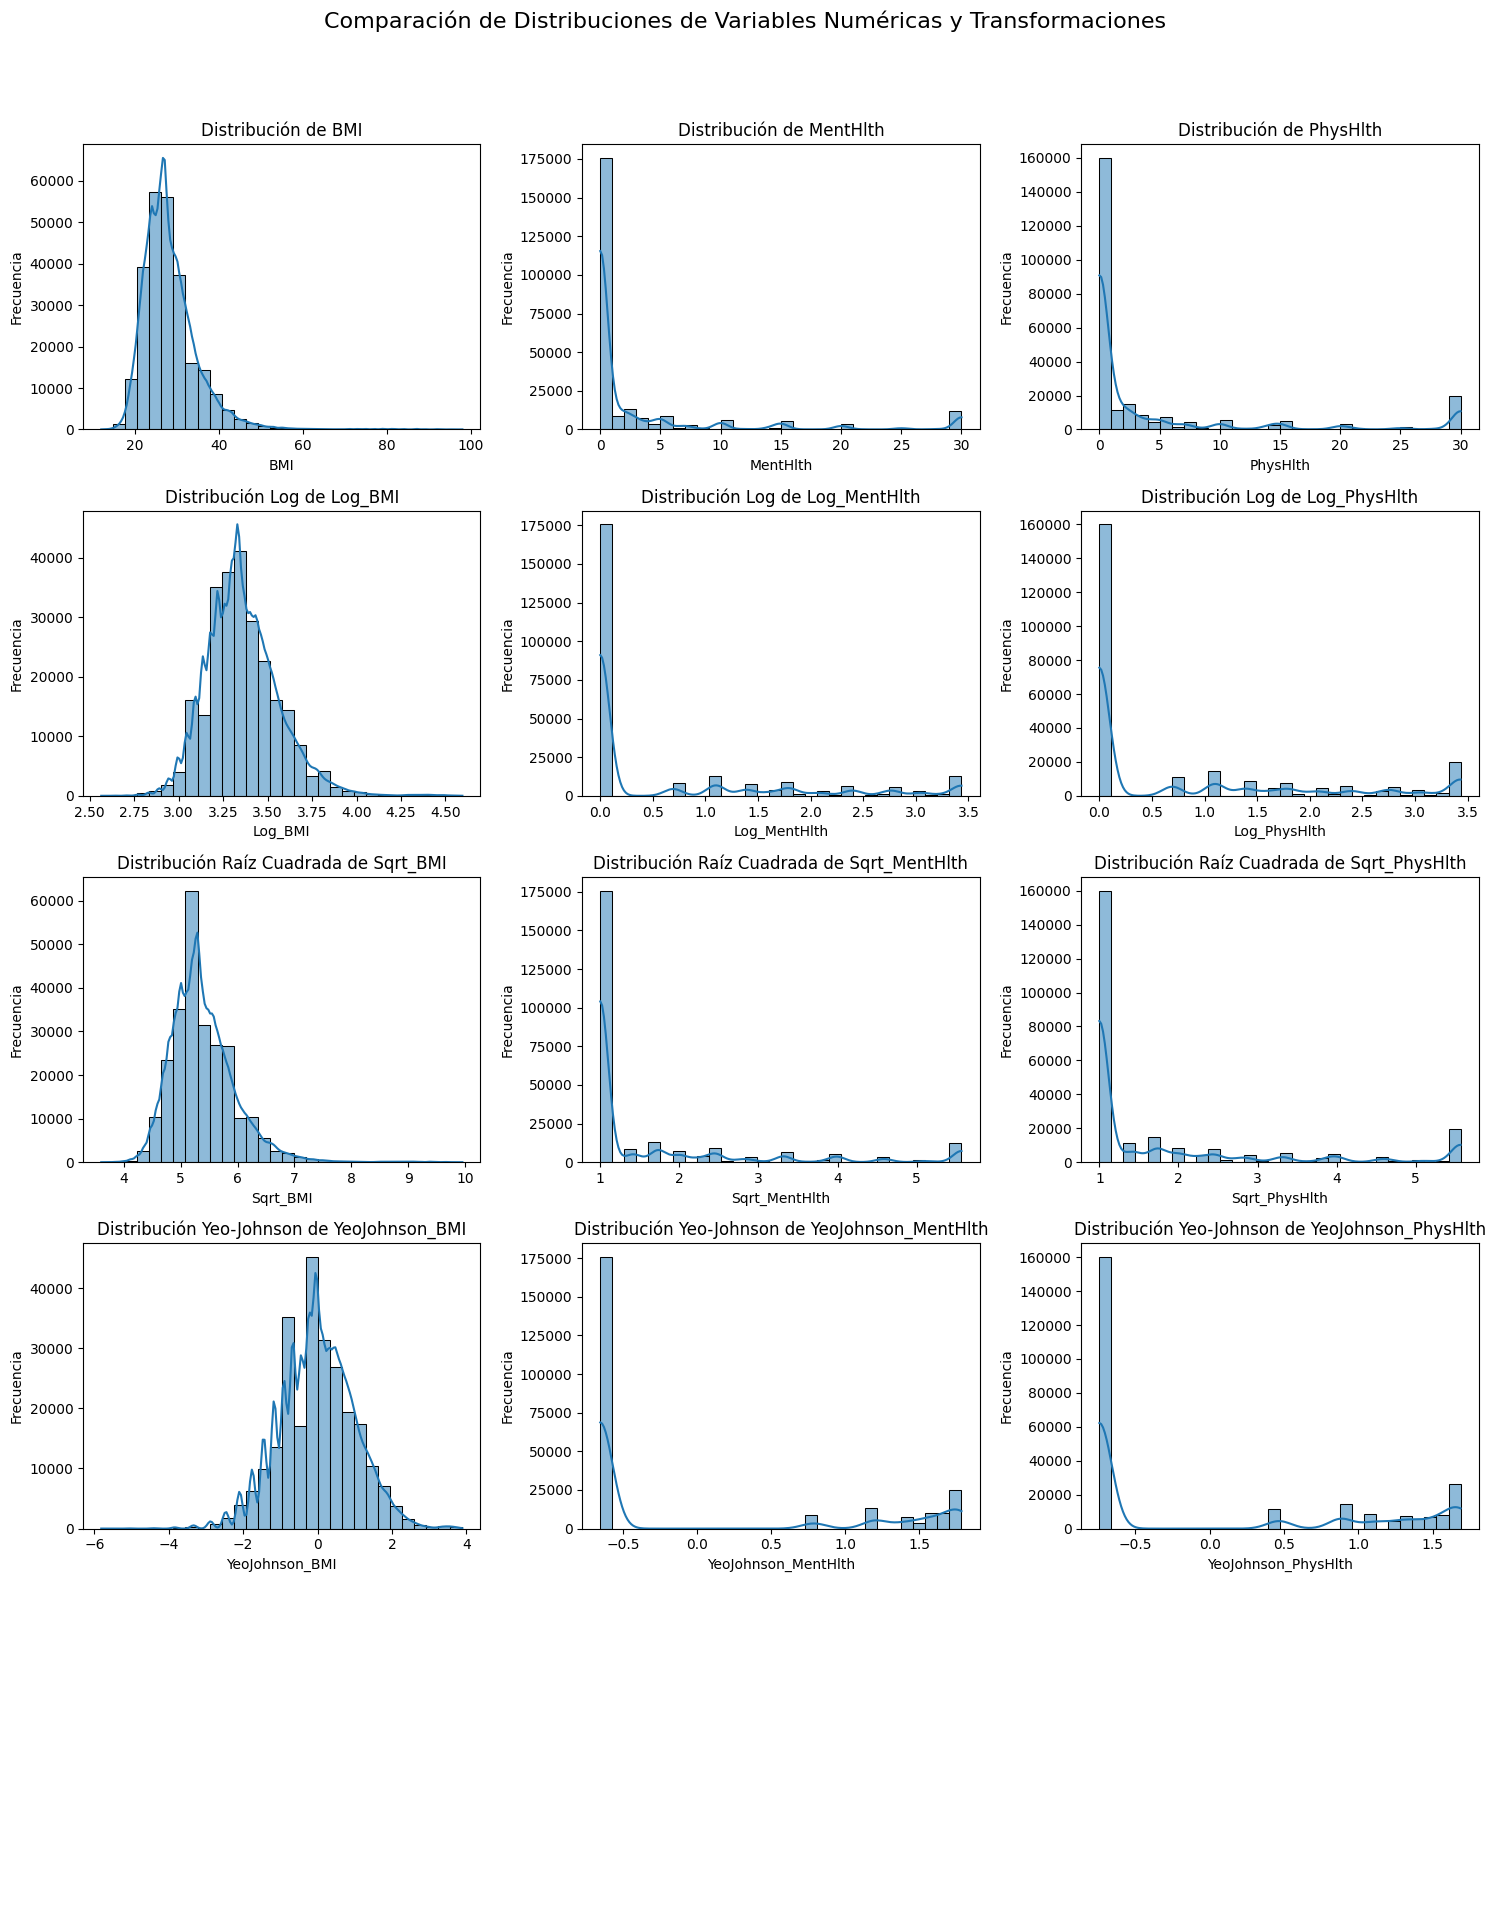

        GenHlth  Age  Education  Income
0             4    8          3       2
1             2    6          5       0
2             4    8          3       7
3             1   10          2       5
4             1   10          4       3
...         ...  ...        ...     ...
253675        2    4          5       6
253676        3   10          1       3
253677        0    1          4       1
253678        2    6          4       0
253679        1    8          5       1

[253680 rows x 4 columns]
             BMI  MentHlth  PhysHlth
0       1.638596  1.756345  1.600664
1      -0.445654 -0.656074 -0.740983
2       0.134514  1.783950  1.687864
3      -0.045740 -0.656074 -0.740983
4      -0.668354  1.387448 -0.740983
...          ...       ...       ...
253675  2.043198 -0.656074  1.316475
253676 -2.467499 -0.656074 -0.740983
253677  0.134514 -0.656074 -0.740983
253678 -0.908655 -0.656074 -0.740983
253679 -0.445654 -0.656074 -0.740983

[253680 rows x 3 columns]


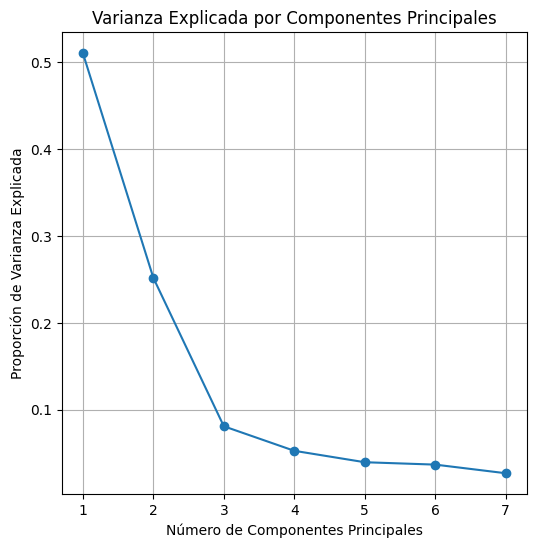

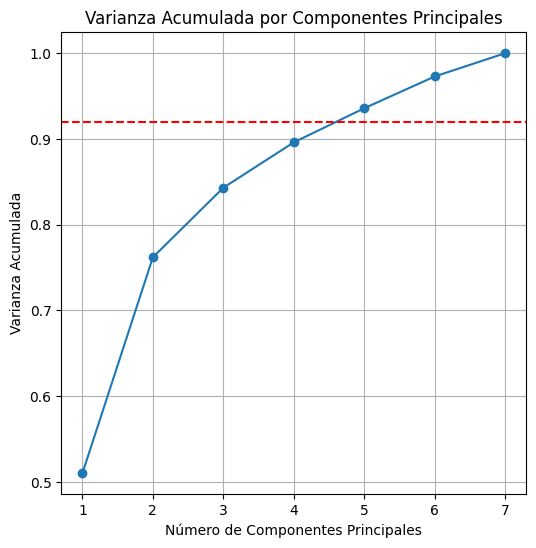

El número mínimo de componentes principales que explica más del 99% de la varianza es: 7
   HighBP  HighChol  CholCheck  Smoker  Stroke  HeartDiseaseorAttack  \
0    True      True       True    True   False                 False   
1   False     False      False    True   False                 False   
2    True      True       True   False   False                 False   
3    True     False       True   False   False                 False   
4    True      True       True   False   False                 False   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  ...  DiffWalk    Sex  \
0         False   False     True              False  ...      True  False   
1          True   False    False              False  ...     False  False   
2         False    True    False              False  ...      True  False   
3          True    True     True              False  ...     False  False   
4          True    True     True              False  ...     False  False   

   Diabetes_bin

In [13]:
modelo.explore_different_transformations(raw_data)
modelo.apply_transformations(raw_data)
df_pca = modelo.apply_pca(raw_data)

In [14]:
df = modelo.true_false_to_one_hot(df_pca)

In [15]:
df.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,DiffWalk,Sex,Diabetes_binary,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,1,1,1,0,0,0,0,1,0,...,1,0,0,1.694009,-4.000470,2.533113,0.462890,0.393024,0.419305,0.238242
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,-0.149524,-4.389937,-2.200268,-0.352470,1.038007,-1.555940,1.080603
2,1,1,1,0,0,0,0,1,0,0,...,1,0,0,0.834423,0.581106,3.737161,-0.511597,-1.269070,0.996445,0.452486
3,1,0,1,0,0,0,1,1,1,0,...,0,0,0,2.996816,0.365710,-0.989803,0.861669,-1.179699,1.355184,-0.439946
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,3.132395,-1.195939,-0.952433,-1.218686,1.118693,1.128947,0.225966


In [16]:
def mi_cm(yreal, ypred):

  cm = confusion_matrix(yreal, ypred)

  text = ['True Negatives','False Positives','False Negatives','True Positives']
  vf = [ '( TN )', '( FP )', '( FN )', '( TP )']
  freq = ["{0:0.0f}".format(value) for value in cm.flatten()]
  percent = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(text,vf, freq,percent)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(6,4))
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
  ax.set(ylabel="Real labels", xlabel="Prediction labels")
  plt.show()

In [17]:
# modelo de regresión logística sin PCA
X_train, X_val, y_train, y_val = train_test_split(df.drop(['Diabetes_binary', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], axis='columns'), df['Diabetes_binary'], train_size=0.80, random_state=10)

In [18]:
X_train.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
218521,0,1,1,0,0,1,1,1,1,0,1,0,0,1
163132,0,0,1,0,0,0,1,0,0,0,1,0,0,1
94025,1,1,1,0,0,0,1,0,1,0,1,0,0,0
83692,1,1,1,0,0,0,1,0,1,0,1,0,1,1
24066,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [19]:
modeloLR = LogisticRegression().fit(X_train, y_train)

In [20]:
predictions = modeloLR.predict(X_val)

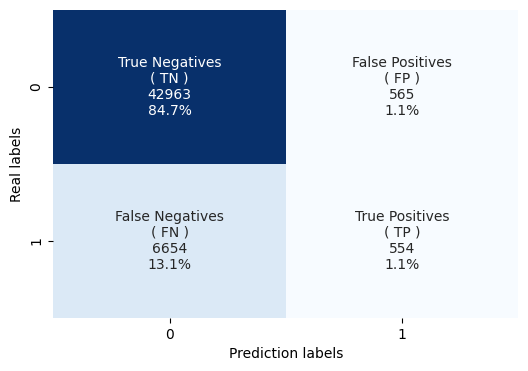

In [14]:
mi_cm(y_val, predictions)

In [15]:
print(accuracy_score(y_val, predictions))
print(recall_score(y_val, predictions))
print(precision_score(y_val, predictions))
print(f1_score(y_val, predictions))

0.8577144433932513
0.07685904550499445
0.49508489722966936
0.13306112645610665


In [16]:
df

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,DiffWalk,Sex,Diabetes_binary,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,1,1,1,0,0,0,0,1,0,...,1,0,0,1.694009,-4.000470,2.533113,0.462890,0.393024,0.419305,0.238242
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,-0.149524,-4.389937,-2.200268,-0.352470,1.038007,-1.555940,1.080603
2,1,1,1,0,0,0,0,1,0,0,...,1,0,0,0.834423,0.581106,3.737161,-0.511597,-1.269070,0.996445,0.452486
3,1,0,1,0,0,0,1,1,1,0,...,0,0,0,2.996816,0.365710,-0.989803,0.861669,-1.179699,1.355184,-0.439946
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,3.132395,-1.195939,-0.952433,-1.218686,1.118693,1.128947,0.225966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,0,0,0,0,1,1,0,...,0,1,0,-3.072084,0.113503,1.659017,1.558964,0.530931,-1.517042,-0.592383
253676,1,1,1,0,0,0,0,0,0,0,...,1,0,1,3.550562,-1.958597,-1.321326,-0.759238,-3.186785,1.218688,1.100054
253677,0,0,1,0,0,0,1,1,0,0,...,0,0,0,-5.313342,-4.236690,-2.894999,0.400735,0.809076,-0.639499,-0.564347
253678,1,0,1,0,0,0,0,1,1,0,...,0,1,0,-0.093474,-4.588192,-2.365090,-0.456188,0.170327,-0.960955,0.915913


In [21]:
X_PCA = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']]

In [22]:
# Aplicando PCA
X_train, X_val, y_train, y_val = train_test_split(X_PCA, df['Diabetes_binary'], train_size=0.80, random_state=10)

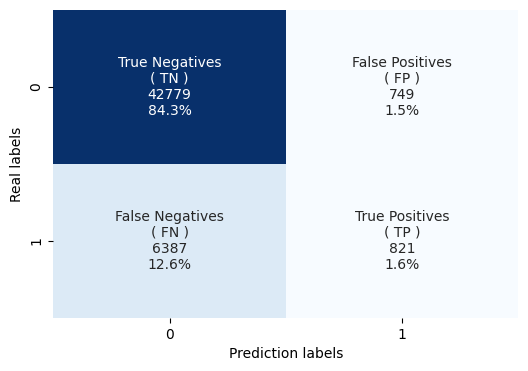

In [20]:
modeloLR = LogisticRegression().fit(X_train, y_train)
predictions = modeloLR.predict(X_val)
mi_cm(y_val, predictions)

In [21]:
print(accuracy_score(y_val, predictions))
print(recall_score(y_val, predictions))
print(precision_score(y_val, predictions))
print(f1_score(y_val, predictions))

0.8593503626616209
0.11390122086570477
0.5229299363057325
0.18705855547960812


In [18]:
# Linear support vector machine
linear_svc_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(random_state=42, dual=False, max_iter=5000)
)
linear_svc_pipeline.fit(X_train, y_train)
y_pred = linear_svc_pipeline.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8595
Precision: 0.8247
Recall: 0.8595
F1-score: 0.8017


In [23]:
from sklearn.pipeline import Pipeline

X_train, X_val, y_train, y_val = train_test_split(X_PCA, df['Diabetes_binary'], train_size=0.80, random_state=10)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(dual=False, random_state=42))
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__loss': ['hinge', 'squared_hinge'],
    'svm__tol': [1e-3, 1e-4, 1e-5],
    'svm__max_iter': [1000, 2000, 5000]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='f1', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

print("\nValidation Set Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_val, y_pred, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_val, y_pred, average='weighted'):.4f}")

feature_importance = np.abs(best_model.named_steps['svm'].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'svm__C': 0.1, 'svm__loss': 'squared_hinge', 'svm__max_iter': 1000, 'svm__tol': 0.001}
Best F1-score: 0.8065308867053409

Validation Set Metrics:
Accuracy: 0.8595
Precision: 0.8247
Recall: 0.8595
F1-score: 0.8017


# oversampling and undersampling

In [27]:
def get_models_underoversampling():
  modelos, nombres = list(), list()

  #  RandOver
  modelos.append(RandomOverSampler())
  nombres.append('RandOver')

  #  TomekLinks
  modelos.append(TomekLinks())
  nombres.append('TomekLinks')

  #  SMOTE
  modelos.append(SMOTE())
  nombres.append('SMOTE')

  # SMOTEENN
  modelos.append(SMOTEENN())
  nombres.append('SMOTEENN')

  return modelos, nombres

In [96]:
modelosOU, nombres = get_models_underoversampling()       
resultados = list()

for i in range(len(modelosOU)):

  model = LogisticRegression()    
  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
  pipe = make_pipeline((modelosOU[i]), (model))


  metrics = {'accuracy': make_scorer(accuracy_score), 
             'recall': make_scorer(recall_score), 
             'f1_score': make_scorer(f1_score),
             'precision': make_scorer(precision_score)
            }

  resultadosOU = cross_validate(pipe,
                                X_train, y_train,
                                scoring=metrics,
                                cv=kfold)

  resultados.append(resultadosOU) 
  print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1_score: %.3f (%.4f)\nmean Precision: %.3f (%.4f)\n' % (nombres[i],
                                                                          np.mean(resultadosOU['test_accuracy']),
                                                                          np.std(resultadosOU['test_accuracy']), 
                                                                          np.mean(resultadosOU['test_recall']),
                                                                          np.std(resultadosOU['test_recall']),
                                                                          np.mean(resultadosOU['test_f1_score']),
                                                                          np.std(resultadosOU['test_f1_score']), 
                                                                          np.mean(resultadosOU['test_precision']),
                                                                          np.std(resultadosOU['test_precision']),  
                                                                          ))

RandOver:
mean Accuracy: 0.719 (0.0020)
mean Recall: 0.746 (0.0039)
mean F1_score: 0.424 (0.0028)
mean Precision: 0.296 (0.0022)

TomekLinks:
mean Accuracy: 0.860 (0.0009)
mean Recall: 0.166 (0.0053)
mean F1_score: 0.247 (0.0069)
mean Precision: 0.487 (0.0101)

SMOTE:
mean Accuracy: 0.720 (0.0022)
mean Recall: 0.742 (0.0038)
mean F1_score: 0.424 (0.0025)
mean Precision: 0.297 (0.0021)

SMOTEENN:
mean Accuracy: 0.718 (0.0022)
mean Recall: 0.740 (0.0033)
mean F1_score: 0.422 (0.0023)
mean Precision: 0.295 (0.0020)



In [29]:
modelosOU, nombres = get_models_underoversampling()       
resultados = list()

for i in range(len(modelosOU)):

  model = LinearSVC(random_state=42, dual=False, C=0.1, loss='squared_hinge', max_iter=1000, tol=0.001)
  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
  pipe = make_pipeline((modelosOU[i]), (model))


  metrics = {'accuracy': make_scorer(accuracy_score), 
             'recall': make_scorer(recall_score), 
             'f1_score': make_scorer(f1_score),
             'precision': make_scorer(precision_score)
            }

  resultadosOU = cross_validate(pipe,
                                X_train, y_train,
                                scoring=metrics,
                                cv=kfold)

  resultados.append(resultadosOU) 
  print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1_score: %.3f (%.4f)\nmean Precision: %.3f (%.4f)\n' % (nombres[i],
                                                                          np.mean(resultadosOU['test_accuracy']),
                                                                          np.std(resultadosOU['test_accuracy']), 
                                                                          np.mean(resultadosOU['test_recall']),
                                                                          np.std(resultadosOU['test_recall']),
                                                                          np.mean(resultadosOU['test_f1_score']),
                                                                          np.std(resultadosOU['test_f1_score']), 
                                                                          np.mean(resultadosOU['test_precision']),
                                                                          np.std(resultadosOU['test_precision']),  
                                                                          ))

RandOver:
mean Accuracy: 0.717 (0.0020)
mean Recall: 0.749 (0.0070)
mean F1_score: 0.423 (0.0034)
mean Precision: 0.295 (0.0024)

TomekLinks:
mean Accuracy: 0.863 (0.0005)
mean Recall: 0.077 (0.0039)
mean F1_score: 0.134 (0.0061)
mean Precision: 0.538 (0.0121)

SMOTE:
mean Accuracy: 0.718 (0.0023)
mean Recall: 0.747 (0.0065)
mean F1_score: 0.423 (0.0023)
mean Precision: 0.295 (0.0018)

SMOTEENN:
mean Accuracy: 0.718 (0.0019)
mean Recall: 0.741 (0.0053)
mean F1_score: 0.421 (0.0021)
mean Precision: 0.294 (0.0016)



In [ ]:
modelosOU, nombres = get_models_underoversampling()       
resultados = list()

for i in range(len(modelosOU)):

  model = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, min_samples_leaf=1)
  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
  pipe = make_pipeline((modelosOU[i]), (model))


  metrics = {
        'accuracy': make_scorer(accuracy_score), 
        'recall': make_scorer(recall_score), 
        'f1_score': make_scorer(f1_score),
        'precision': make_scorer(precision_score)
    }


  resultadosOU = cross_validate(pipe,
                                X_train, y_train,
                                scoring=metrics,
                                cv=kfold)

  resultados.append(resultadosOU) 
  print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1_score: %.3f (%.4f)\nmean Precision: %.3f (%.4f)\n' % (
        nombres[i],
        np.mean(resultadosOU['test_accuracy']),
        np.std(resultadosOU['test_accuracy']), 
        np.mean(resultadosOU['test_recall']),
        np.std(resultadosOU['test_recall']),
        np.mean(resultadosOU['test_f1_score']),
        np.std(resultadosOU['test_f1_score']), 
        np.mean(resultadosOU['test_precision']),
        np.std(resultadosOU['test_precision'])
    ))


In [51]:
mlflow.set_tracking_uri(uri="http://localhost:5000")

In [52]:
mlflow.set_experiment("Diabetes_Diagnostic")

2024/10/19 08:46:49 INFO mlflow.tracking.fluent: Experiment with name 'Diabetes_Diagnostic' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/107230228862051807', creation_time=1729349209099, experiment_id='107230228862051807', last_update_time=1729349209099, lifecycle_stage='active', name='Diabetes_Diagnostic', tags={}>

In [70]:
class process_model:
    def __init__(self):
        pass
    class model_statistics:
        def __init__(self,yreal,ypred):
            self.yreal = yreal
            self.ypred = ypred
            self.my_accuracy(yreal, ypred)
            self.my_recall(yreal, ypred)
            self.my_gmean(yreal, ypred)
            self.my_precision(yreal, ypred)
            self.my_f1_score(yreal, ypred)
            self.mi_cm(yreal, ypred)
    
        def my_accuracy(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            tot = confusion_matrix(yreal, ypred).sum()
            return (vp + vn) / tot
        
        def my_recall(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            return vp / (vp + fn)
        
        def my_gmean(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            especificidad = vn / (vn + fp)
            recall = self.my_recall(yreal, ypred)  # Cambia a self
            return np.sqrt(recall * especificidad)
        
        def my_precision(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            return vp / (vp + fp)
        
        def my_f1_score(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            return (2 * vp) / (2 * vp + fp + fn)
    
        def mi_cm(yreal, ypred,name):
            cm = confusion_matrix(yreal, ypred)
            text = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
            vf = ['( TN )', '( FP )', '( FN )', '( TP )']
            freq = ["{0:0.0f}".format(value) for value in cm.flatten()]
            percent = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]
            
            labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(text, vf, freq, percent)]
            labels = np.asarray(labels).reshape(2, 2)
            
            plt.figure(figsize=(6, 4))
            ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=False)
            ax.set(ylabel="Real labels", xlabel="Prediction labels")
            name_confussion_matrix="confussion_matrix_"+name+".png"
            plt.savefig(name_confussion_matrix)
            plt.show()
            
    class list_models:
        def __init__(self):
            self.instance_uo, self.modelos, self.nombres,self.params = self.get_models_underoversampling()
            self.creation_models()
            
        def get_models_underoversampling(self):
            instance_uo, modelos, nombres = list(), list(), list()
            dict_uo = {1: RandomOverSampler(), 2: TomekLinks(), 3: SMOTE(), 4: SMOTEENN()}
            dict_nombres = {0: 'Log', 1: 'Log_RandOver', 2: 'Log_TomekLinks', 3: 'Log_SMOTE', 4: 'Log_SMOTEENN', 5: 'RandForest'}
            dict_params={0:{'n_estimators':200,'random_state':42},1:{'class_weight':'balanced'}}
            for i in range(6):
                if i in [0, 5]:
                    instance_uo.append(np.NaN)
                else:
                    instance_uo.append(dict_uo.get(i))
                if i == 0:
                    modelos.append(LogisticRegression())
                    params=np.NaN
                elif i == 5:
                    params=dict_params.get(0)
                    modelos.append(RandomForestClassifier(**params))
                else:
                    params=dict_params.get(1)
                    modelos.append(LogisticRegression(**params))
                nombres.append(dict_nombres.get(i))
            return instance_uo, modelos, nombres,params

        def registation_models(self,name,model):
            with mlflow.start_run(run_name=name):
                mlflow.log_params(self.params)
                mlflow.log_metrics({"mean_accuracy": self.mean_accuracy,"std_accuracy": self.std_accuracy,
                                   "mean_recall": self.mean_recall,"std_recall": self.std_recall,
                                  "mean_f1": self.mean_f1,"accuracy": self.std_f1}
                                  )
                # Log the model
                mlflow.sklearn.log_model(model, artifact_path="models")
            
        
        def creation_models(self):
            
            for inst_uo, model, name in zip(self.instance_uo, self.modelos, self.nombres):
                resultados=[]
                if type(inst_uo)==float:
                    model_pipeline=make_pipeline(model)   
                else:
                    model_pipeline = make_pipeline((inst_uo),(model))
                
                
                metrics = {'accuracy','recall','f1'}
                kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
                resultadosOU = cross_validate(model_pipeline, X_train, y_train, scoring=metrics, cv=kfold)
                resultados.append(resultadosOU)
                
                self.mean_accuracy=np.mean(resultadosOU['test_accuracy'])
                self.std_accuracy=np.std(resultadosOU['test_accuracy'])

                self.mean_recall=np.mean(resultadosOU['test_recall'])
                self.std_recall=np.std(resultadosOU['test_recall'])

                self.mean_f1=np.mean(resultadosOU['test_f1'])
                self.std_f1=np.std(resultadosOU['test_f1'])
                
                model_pipeline.fit(X_train,y_train)
                predictions=model_pipeline.predict(X_val)
                self.registation_models(name,model)
                process_model.model_statistics.mi_cm(y_val,predictions,name)
                
            # return mean_accuracy,std_accuracy,mean_recall,std_recall,mean_recall,std_recall, predictions, model_pipeline
                # process_model.model_statistics.mi_cm(y_val,predictions)        

2024/10/19 11:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:43:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Log at: http://localhost:5000/#/experiments/107230228862051807/runs/671a94bace3f466b80207156924fe796.
2024/10/19 11:43:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/107230228862051807.


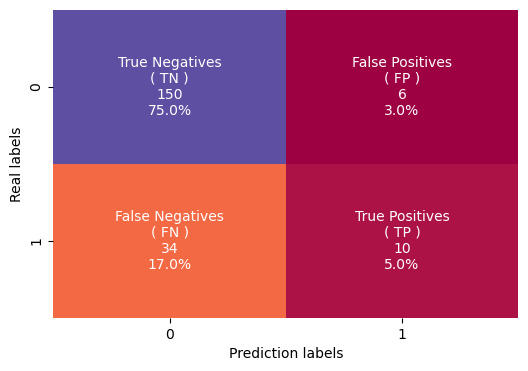

2024/10/19 11:43:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:43:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Log_RandOver at: http://localhost:5000/#/experiments/107230228862051807/runs/3bb520a8b53048b3bef260c1a0d0fa10.
2024/10/19 11:43:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/107230228862051807.


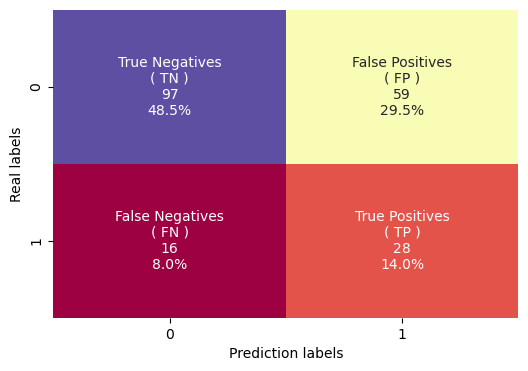

2024/10/19 11:43:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:43:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run Log_TomekLinks at: http://localhost:5000/#/experiments/107230228862051807/runs/f15209d0332b416a98f9ad618e96d77a.
2024/10/19 11:43:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/107230228862051807.


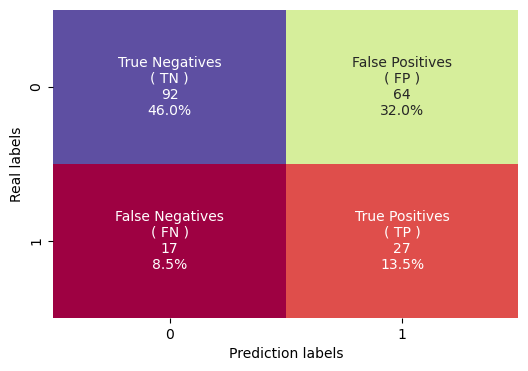

2024/10/19 11:44:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:44:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Log_SMOTE at: http://localhost:5000/#/experiments/107230228862051807/runs/b91c57764c644751b844b8d4a2ddcb8d.
2024/10/19 11:44:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/107230228862051807.


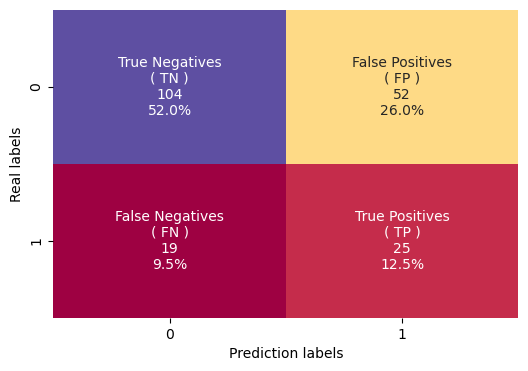

2024/10/19 11:44:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:44:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Log_SMOTEENN at: http://localhost:5000/#/experiments/107230228862051807/runs/aa9ed533a89041c7aec6ec221679bace.
2024/10/19 11:44:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/107230228862051807.


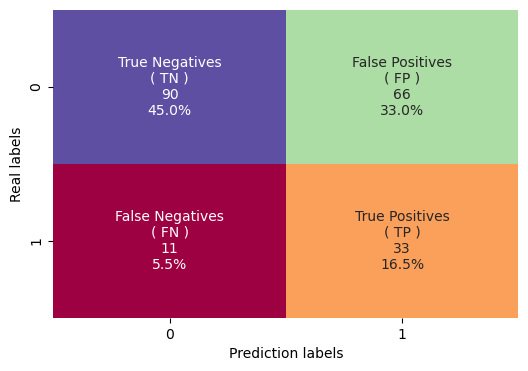

2024/10/19 11:44:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 11:44:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandForest at: http://localhost:5000/#/experiments/107230228862051807/runs/48771bd29451489395176c925853e769.
2024/10/19 11:44:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/107230228862051807.


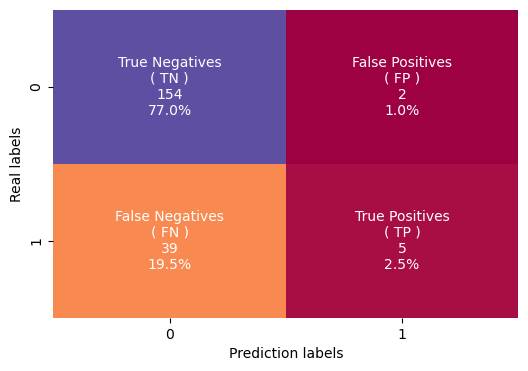

In [71]:
process=process_model()
process.list_models()